This notebook attempts rotation as implemented in [this Monai tutorial](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/modules/3d_image_transforms.ipynb#scrollTo=soJiHn_Wj6gy)

In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
import nilearn as nil
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os
import numpy as np
import monai

import torch
from torch.utils.data import DataLoader

from nibabel import save
from nilearn import image
from nilearn.image import get_data
from nilearn.plotting import show

from monai.transforms import (
    EnsureChannelFirstd,
    LoadImaged,
    BorderPadd,
    RandAffined,
    Affined,
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    SaveImaged,
    ScaleIntensityd,
)
from monai.config import print_config
from monai.apps import download_and_extract
from monai.utils import set_determinism, first

import os
import shutil
import glob as glob

print_config()

MONAI version: 1.2.0
Numpy version: 1.25.0
Pytorch version: 2.0.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /home/chloe/.conda/envs/torch/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.20.0
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://doc

Create dataset path and dictionary

In [2]:
data_dir = "data/"

train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTs", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

Load the images to visualize a sampling and get data dimensions

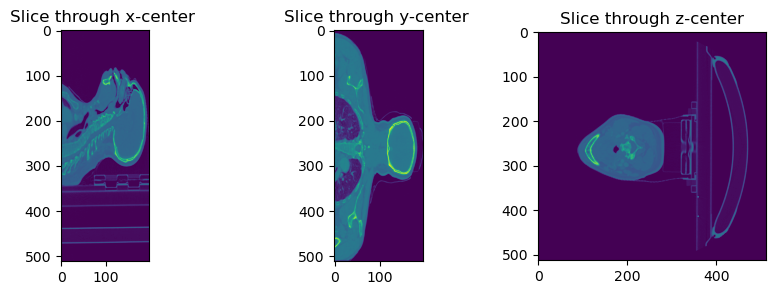

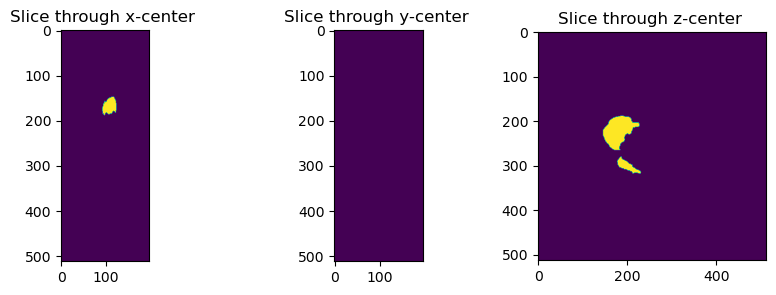

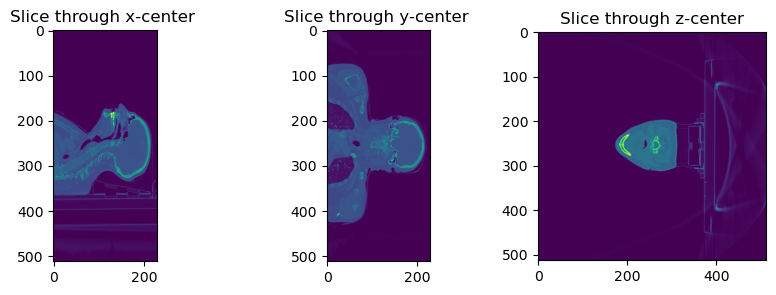

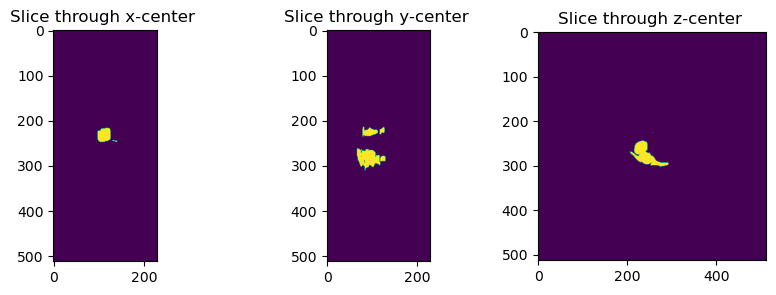

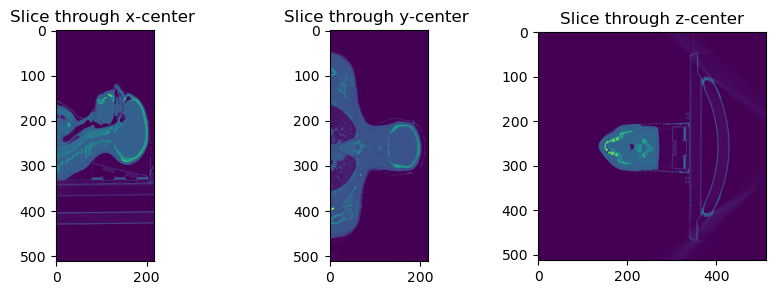

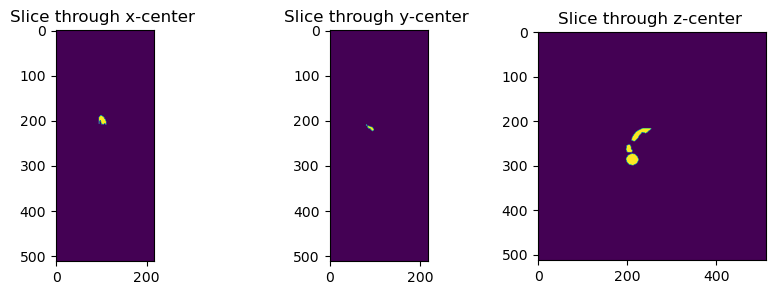

In [3]:
dimensions = np.zeros([len(data_dicts),3])

for index in range(len(data_dicts)):
    img_path = data_dicts[index]['image']
    lbl_path = data_dicts[index]['label']
    before_rot = image.load_img(img_path)
    before_rot_label = image.load_img(lbl_path)
    dimension = before_rot.shape
    dimensions[index] = dimension

    center = np.divide(dimension,2)
    x_cen = int(np.ceil(center[0]))
    y_cen = int(np.ceil(center[1]))
    z_cen = int(np.ceil(center[2]))

    fig = plt.figure("visualize", (len(data_dicts), 3))
    fig.set_size_inches(10,3)
    plt.subplot(1, 3, 1)
    plt.title(f"Slice through x-center ")
    plt.imshow(get_data(before_rot)[x_cen, :, :])
    plt.subplot(1, 3, 2)
    plt.title(f"Slice through y-center ")
    plt.imshow(get_data(before_rot)[:, y_cen, :])
    plt.subplot(1, 3, 3)
    plt.title(f"Slice through z-center")
    plt.imshow(get_data(before_rot)[:, :, z_cen])
    plt.show()

    fig = plt.figure("labels", (len(data_dicts), 3))
    fig.set_size_inches(10,3)
    plt.subplot(1, 3, 1)
    plt.title(f"Slice through x-center ")
    plt.imshow(get_data(before_rot_label)[x_cen, :, :])
    plt.subplot(1, 3, 2)
    plt.title(f"Slice through y-center ")
    plt.imshow(get_data(before_rot_label)[:, y_cen, :])
    plt.subplot(1, 3, 3)
    plt.title(f"Slice through z-center ")
    plt.imshow(get_data(before_rot_label)[:, :, z_cen])
    plt.show()
    

Visualize all the dimensions

In [4]:
print(dimensions)

[[512. 512. 196.]
 [512. 512. 229.]
 [512. 512. 217.]]


Set axis of rotation: 
- x = 0
- y = 1
- z = 2

Set starting degree, ending degree of rotation, and rotation step.

This code will produce rotations increaseing from starting degree to ending degree with step of chosen degree (ensure this divides evenly). 

For control experiment, only rotating with zero degree.

In [5]:
axis = 2

start_deg = 0
end_deg = 0
step = 1

if (start_deg - end_deg)%step != 0:
    print("Step does not divide evenly: choose different rotation parameters.")

Loop over all rotations: Use get_dim_about_z notebook in order to get x,y dimensions using your maximum rotation. For rotations between -30 to 30 degrees, we have a maximum x and y dimension of 585. We are using same set dist and protocol from general rotations as the control group. We are using the same z value as given in the original image. 

In [7]:
set_dist = 594

deg_array = np.zeros(3)
deg_array[axis] = start_deg - step

#Loop over specified range of degrees
while deg_array[axis] < end_deg:

    #Set degree for iteration
    deg_array[axis] = deg_array[axis] + step
    deg_array_rad = np.deg2rad(deg_array)

    a, b, c = deg_array[0], deg_array[1], deg_array[2]
    a_rad, b_rad, c_rad = deg_array_rad[0], deg_array_rad[1], deg_array_rad[2]

    #Create folders to store control images and labels
    image_path = f'results/control_results/control_images/' 
    if not os.path.exists(image_path):
        os.makedirs(image_path)

    label_path = f'results/control_results/control_labels/' 
    if not os.path.exists(label_path):
        os.makedirs(label_path)

    #Produce control image with maximum padding for each image
    for index in range(len(data_dicts)):
        data_transform = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                EnsureChannelFirstd(keys=["image", "label"]),
                BorderPadd(keys=["image"],
                        spatial_border = 1, 
                        mode='constant', 
                        lazy=False, 
                        constant_values = -1024),
                BorderPadd(keys=["label"],
                        spatial_border = 1, 
                        mode='constant', 
                        lazy=False,
                        constant_values = 0),
                Affined(keys=["image", "label"],
                    rotate_params = (a_rad, b_rad, c_rad),
                    mode=('bilinear','nearest'),
                    padding_mode=('border'),
                    spatial_size = (set_dist, set_dist, -1),
                    align_corners = True
                ),
                SaveImaged(keys=["image"],
                    output_dir=image_path, 
                    output_postfix =  f"control_image_{a}_{b}_{c}_0000",
                    output_ext=".nii.gz",
                    resample = False),
                SaveImaged(keys=["label"],
                    output_dir=label_path, 
                    output_postfix =  f"control_label_{a}_{b}_{c}",
                    output_ext=".nii.gz",
                    resample = False),
            ])

        #Runs transformation with specified shape
        transformed_data_dict = data_transform(data_dicts[index])
    

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


2023-08-18 17:06:44,130 INFO image_writer.py:197 - writing: results/control_results/control_images/HN_P002_pre_0000/HN_P002_pre_0000_control_image_0.0_0.0_0.0_0000.nii.gz
2023-08-18 17:06:49,722 INFO image_writer.py:197 - writing: results/control_results/control_labels/HN_P002_pre/HN_P002_pre_control_label_0.0_0.0_0.0.nii.gz
2023-08-18 17:06:57,747 INFO image_writer.py:197 - writing: results/control_results/control_images/HN_P003_pre_0000/HN_P003_pre_0000_control_image_0.0_0.0_0.0_0000.nii.gz
2023-08-18 17:07:04,241 INFO image_writer.py:197 - writing: results/control_results/control_labels/HN_P003_pre/HN_P003_pre_control_label_0.0_0.0_0.0.nii.gz
2023-08-18 17:07:12,982 INFO image_writer.py:197 - writing: results/control_results/control_images/HN_P005_pre_0000/HN_P005_pre_0000_control_image_0.0_0.0_0.0_0000.nii.gz
2023-08-18 17:07:18,862 INFO image_writer.py:197 - writing: results/control_results/control_labels/HN_P005_pre/HN_P005_pre_control_label_0.0_0.0_0.0.nii.gz


Create images transformed by only loading and saving

In [9]:
#Create folders to store control images and labels
image_path = f'results/control_results/control_images/' 
if not os.path.exists(image_path):
    os.makedirs(image_path)

label_path = f'results/control_results/control_labels/' 
if not os.path.exists(label_path):
    os.makedirs(label_path)

#Produce control image with maximum padding for each image
for index in range(len(data_dicts)):
    data_transform = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            SaveImaged(keys=["image"],
                output_dir=image_path, 
                output_postfix =  f"load_save_image_{a}_{b}_{c}_0000",
                output_ext=".nii.gz",
                resample = False),
            SaveImaged(keys=["label"],
                output_dir=label_path, 
                output_postfix =  f"load_save_label_{a}_{b}_{c}",
                output_ext=".nii.gz",
                resample = False),
        ])

    #Runs transformation with specified shape
    transformed_data_dict = data_transform(data_dicts[index])

2023-08-18 17:07:51,280 INFO image_writer.py:197 - writing: results/control_results/control_images/HN_P002_pre_0000/HN_P002_pre_0000_load_save_image_0.0_0.0_0.0_0000.nii.gz
2023-08-18 17:07:54,170 INFO image_writer.py:197 - writing: results/control_results/control_labels/HN_P002_pre/HN_P002_pre_load_save_label_0.0_0.0_0.0.nii.gz
2023-08-18 17:07:57,706 INFO image_writer.py:197 - writing: results/control_results/control_images/HN_P003_pre_0000/HN_P003_pre_0000_load_save_image_0.0_0.0_0.0_0000.nii.gz
2023-08-18 17:08:01,018 INFO image_writer.py:197 - writing: results/control_results/control_labels/HN_P003_pre/HN_P003_pre_load_save_label_0.0_0.0_0.0.nii.gz
2023-08-18 17:08:04,794 INFO image_writer.py:197 - writing: results/control_results/control_images/HN_P005_pre_0000/HN_P005_pre_0000_load_save_image_0.0_0.0_0.0_0000.nii.gz
2023-08-18 17:08:07,629 INFO image_writer.py:197 - writing: results/control_results/control_labels/HN_P005_pre/HN_P005_pre_load_save_label_0.0_0.0_0.0.nii.gz


Copy control images (0 rot with padding) and load_save images into nnUnet folder for testing

In [10]:
# Define the path to where you store transformed data and where to store nnUnet data
transform_image_dir = 'results/control_results/control_images'
nnUnet_data_path = '/home/chloe/nnUNet_raw_data_base/nnUNet_raw_data/Task603_SettingUp/imagesTs' #Change to where you store nnUnet data

# Code to move transformed data from subfolders to single folder
patient_names = os.listdir(transform_image_dir)
for patient in patient_names:
    patient_path = os.path.join(transform_image_dir, patient)
    image_names = os.listdir(patient_path)
    for image in image_names:
        image_path = os.path.join(patient_path, image)
        shutil.copy(image_path, nnUnet_data_path)

print("Files copied")

Files copied


Copy original Images into nnUnet folder for testing

In [11]:
# Define the path to where you store original data and where to store nnUnet data
original_image_dir = 'data/imagesTs'

# Code to move transformed data from subfolders to single folder
patient_images = os.listdir(original_image_dir)
for patient in patient_images:
    patient_path = os.path.join(original_image_dir, patient)
    shutil.copy(patient_path, nnUnet_data_path)

print("Files copied")

Files copied


Visualize the control group (padding with no rotation)

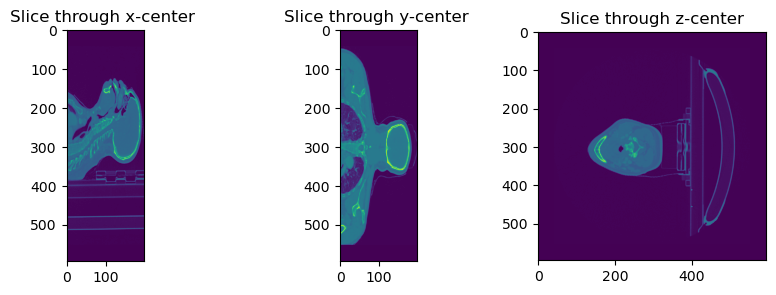

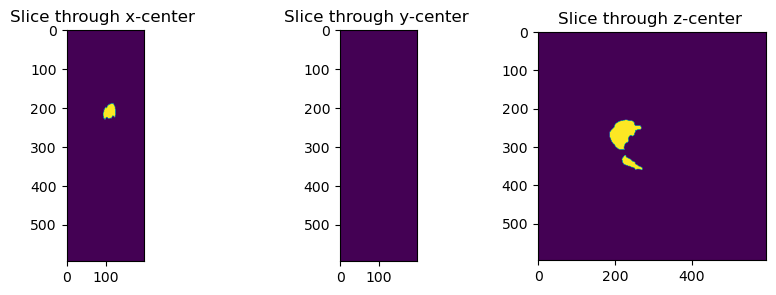

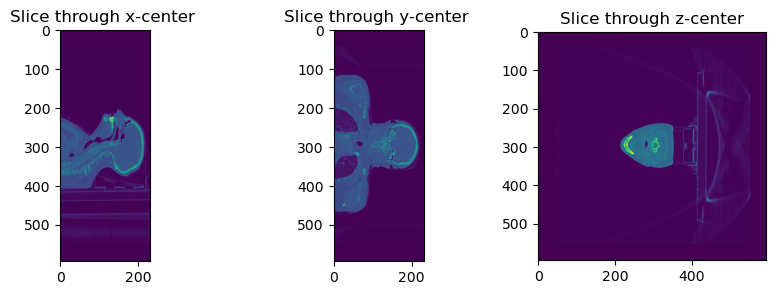

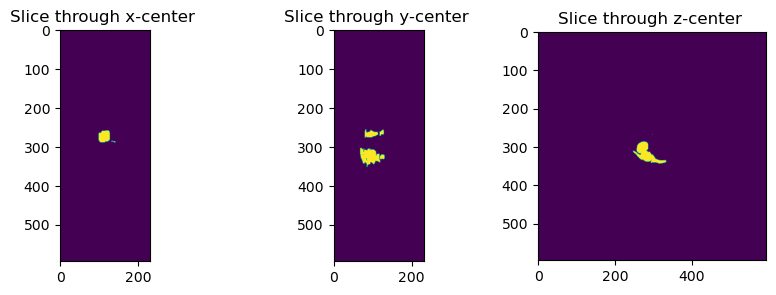

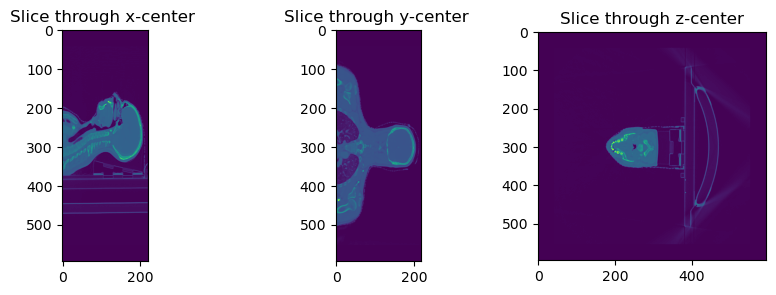

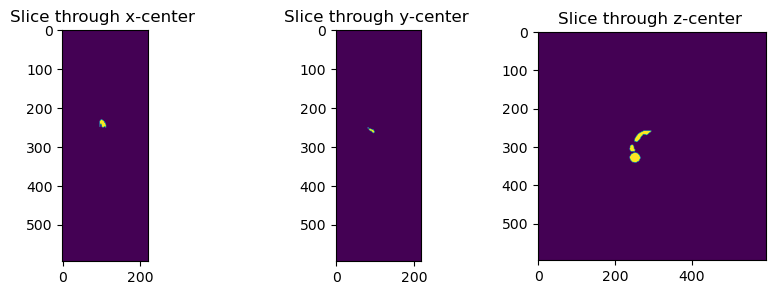

In [14]:
from nilearn import image

image_path = 'results/control_results/control_images'
label_path = 'results/control_results/control_labels'
for index in range(len(data_dicts)):
    a, b, c = 0.0, 0.0, 0.0
    img_str = data_dicts[index]['image'].strip("data/imagesTs/").strip(".nii.gz")
    lbl_str = data_dicts[index]['image'].strip("data/imagesTs/").strip("_0000.nii.gz")
    img_path = image_path + "/" + img_str + "/" + img_str + f"_control_image_{a}_{b}_{c}_0000" + '.nii.gz'
    lbl_path = label_path + "/" +lbl_str + "/" + lbl_str + f"_control_label_{a}_{b}_{c}" + '.nii.gz'
    after_rot = image.load_img(img_path)
    after_rot_label = image.load_img(lbl_path)
    dimension = after_rot.shape

    center = np.divide(dimension,2)
    x_cen = int(np.ceil(center[0]))
    y_cen = int(np.ceil(center[1]))
    z_cen = int(np.ceil(center[2]))

    fig = plt.figure("visualize", (len(data_dicts), 3))
    fig.set_size_inches(10,3)
    plt.subplot(1, 3, 1)
    plt.title(f"Slice through x-center ")
    plt.imshow(get_data(after_rot)[x_cen, :, :])
    plt.subplot(1, 3, 2)
    plt.title(f"Slice through y-center ")
    plt.imshow(get_data(after_rot)[:, y_cen, :])
    plt.subplot(1, 3, 3)
    plt.title(f"Slice through z-center")
    plt.imshow(get_data(after_rot)[:, :, z_cen])
    plt.show()

    fig = plt.figure("labels", (len(data_dicts), 3))
    fig.set_size_inches(10,3)
    plt.subplot(1, 3, 1)
    plt.title(f"Slice through x-center ")
    plt.imshow(get_data(after_rot_label)[x_cen, :, :])
    plt.subplot(1, 3, 2)
    plt.title(f"Slice through y-center ")
    plt.imshow(get_data(after_rot_label)[:, y_cen, :])
    plt.subplot(1, 3, 3)
    plt.title(f"Slice through z-center ")
    plt.imshow(get_data(after_rot_label)[:, :, z_cen])
    plt.show()